In [0]:
#https://stackoverflow.com/questions/51888118/how-to-downgrade-tensorflow-version-in-colab?rq=1
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1
!nvcc --version
!pip install tensorflow-gpu==1.11.0

In [0]:
from google.colab import drive

import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os, cv2, random, pickle

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

print(tf.__version__)
print(keras.__version__)

training_data_dir = '/content/drive/My Drive/NERC Colab/newData/'
#training_data_dir = '/content/drive/My Drive/NERC Colab/5-28 data/'

frame_dir = training_data_dir + 'preprocessed_frames/'
label_dir = training_data_dir + 'labels/'

IMG_SIZE_X, IMG_SIZE_Y = 180, 135

drive.mount('/content/drive')

1.14.0-rc1
2.2.4-tf
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
training_data = []

def create_training_data():
    for img in os.listdir(frame_dir):
        i = img[:len(img) - 4]
        img_array = cv2.imread(os.path.join(frame_dir, img))

        f = open(os.path.join(label_dir, str(i) + '.txt'), 'r')
        label = float(f.read())
        f.close()

        training_data.append([img_array, label])
        
        if len(training_data) % 100 == 0:
          print(len(training_data))

    random.shuffle(training_data)

create_training_data()

X, y = [], []
for features, label in training_data:
    X.append(features)
    y.append(label)

print(len(X))
print(len(y))

In [0]:
#Remove bad data
for i in range(len(X)):
  if len(X[i]) != 135:
    print(i)
    X.pop(i)
    y.pop(i)
X = np.array(X).reshape(-1, IMG_SIZE_Y, IMG_SIZE_X, 3)
X = X/255.0

In [0]:
'''
Save the data in array form
Still experimenting with the best solution - pickle has too much overhead and
exceeds Colab session memory
'''

print(len(X))
print(len(y))

training_data = None

np.save(training_data_dir + "X.npy", X)
np.save(training_data_dir + "y.npy", y)


'''
pickle_out = open(training_data_dir + "X.pickle","wb")
pickle.dump(X, pickle_out, protocol=4)
pickle_out.close()
print("Done with pickle X!!!")

pickle_out = open(training_data_dir + "y.pickle","wb")
pickle.dump(y, pickle_out, protocol=4)
pickle_out.close()

pickle_in = open(training_data_dir + "X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open(training_data_dir + "y.pickle","rb")
y = pickle.load(pickle_in)
'''

In [0]:
X = np.load(training_data_dir + "X.npy")
y = np.load(training_data_dir + "y.npy")

(135, 180, 3)


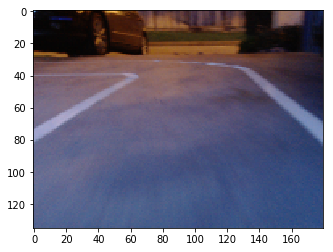

In [0]:
print(X[0].shape)
plt.imshow(X[0])

In [0]:
model = tf.keras.models.Sequential()

model.add(Conv2D(24, (5, 5), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(100))
model.add(Activation('linear'))
model.add(Dropout(0.25))

model.add(Dense(50))
model.add(Activation('linear'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('linear'))

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]#,
             #keras.callbacks.ModelCheckpoint(filepath=training_data_dir + 'NickModel.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse', 'mae'])

model.fit(X, y, batch_size=64, epochs=100, callbacks=callbacks, validation_split=0.3)


Train on 5341 samples, validate on 2290 samples
Epoch 1/100
5341/5341 [==============================] - 18s 3ms/step - loss: 0.3823 - mean_squared_error: 0.3823 - mean_absolute_error: 0.4691 - val_loss: 0.3827 - val_mean_squared_error: 0.3827 - val_mean_absolute_error: 0.4852
Epoch 2/100
5341/5341 [==============================] - 8s 1ms/step - loss: 0.2955 - mean_squared_error: 0.2955 - mean_absolute_error: 0.4003 - val_loss: 0.2386 - val_mean_squared_error: 0.2386 - val_mean_absolute_error: 0.3562
Epoch 3/100
5341/5341 [==============================] - 8s 1ms/step - loss: 0.1925 - mean_squared_error: 0.1925 - mean_absolute_error: 0.3157 - val_loss: 0.1639 - val_mean_squared_error: 0.1639 - val_mean_absolute_error: 0.2943
Epoch 4/100
5341/5341 [==============================] - 8s 1ms/step - loss: 0.1494 - mean_squared_error: 0.1494 - mean_absolute_error: 0.2770 - val_loss: 0.1408 - val_mean_squared_error: 0.1408 - val_mean_absolute_error: 0.2727
Epoch 5/100
5341/5341 [============

In [0]:

#model.save(training_data_dir + 'NickModel_tf-11.0.h5')

#model = keras.models.load_model(training_data_dir + 'NickModel.h5')


#test one frame
'''
img1 = cv2.imread(training_data_dir + 'preprocessed_frames/1899.png')
plt.imshow(img1)
print(model.predict(np.array([img1]) / 255.0))
'''

#prints out each time steering angle is off by more than 0.5
'''
ls = []
for i in range(len(X)):
  img, ans = X[i], y[i]
  pred = model.predict(np.array([img]))[0][0]
  if abs(ans - pred) > 0.5:
    print(ans, pred)
'''

#calculates average error in steering angle
'''
ls = []
for i in range(len(X)):
  img, ans = X[i], y[i]
  pred = model.predict(np.array([img]))[0][0]
  ls.append(abs(pred - ans))
  
print(sum(ls) / len(ls))
''''''

0.12272954537391018
